<a href="https://colab.research.google.com/github/lapythie/ml/blob/master/HW07_ML_cnn_quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание:

В домашке вам нужно будет обучить большую сверточную модель на символах (отличаться по сути будет только токенизация).

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру.

Конкретнее задание такое: Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга. Должен быть хотя бы один слой каждого типа.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Сделайте размер эмбединга сильно меньше. Попробуйте паддинг поменьше. Символьная модель может обучаться намного дольше. Иногда кернел может крашиться просто так или из-за слишком больших матриц.



In [ ]:
# !unzip '/content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_lectures/Нейронки 9.04/data.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/homework_ml_m1/ML_lectures/Нейронки 9.04/data.zip
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [ ]:
import tensorflow as tf

In [ ]:
import re
import unicodedata
import pandas as pd
import numpy as np
from string import punctuation, digits
punctuation += '«»—–…“”‘•∘'
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def preprocess(text):
    '''no lowering'''
    tokens = text.split()
    punc = str(list(set(punctuation)-set('[\^\}\?\@…!\$\{\#\.]')))
    tokens = [token.strip(punc) for token in tokens]
    return tokens

from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Предобработка

In [ ]:
from nltk import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Вообще говоря, нам хотелось бы сохранить экспрессивную пунктуацию, пунктуацию на границе предложения и цифры

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»—–…“”‘•∘'

In [ ]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(text)
    
filtered_vocab = set()

for sym in vocab:
    if vocab[sym] > 2000:
        filtered_vocab.add(sym)
len(filtered_vocab)

88

In [ ]:
def cut_space(s):
    return re.sub('[\n\s\t]+', ' ', s)

# такую пунктуацию оставим
# потому что попадаются вопросы с просьбой решить математические примеры
pun = set('\^\}\?\@…!\$\{\#\.')
filtered_vocab = filtered_vocab-(pun|set(digits)|(filtered_vocab&set(punctuation)))
def cust_tokenize(s):
    tokens = []
    for char in s:
        if char in digits:
            tokens.append('DIG')
        elif char in pun:
            tokens.append('PUN')
        elif char in filtered_vocab:
            tokens.append(char)
        else:
            tokens.append('UNK')
    return tokens


# s = 'How di.d Otto 1 000 000 von Guericke! ? used 1.56 the Magdeburg? I dunno'
# for func in (keep_alpha, dig_token, num_token, keep_punct):
#     print (func(s))

In [ ]:
quora = pd.read_csv('quora.csv')

In [ ]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)
# quora[quora['target']==1]

In [ ]:
quora['sents'] = quora['question_text'].apply(sent_tokenize)
quora['sent_count'] = quora['sents'].apply(lambda x: len(x))
quora['text_len'] = quora['question_text'].apply(lambda x: len(x))

In [ ]:
quora['tokenized_text'] = quora['question_text'].apply(lambda x: cust_tokenize(cut_space(x)))

In [ ]:
# quora['sent_count'].unique()
# quora.groupby(by=['sent_count', 'target']).agg('count')
for i in range(5, 12):
    ind = quora[quora['sent_count']==i].index[0]
    print(quora.loc[ind, 'question_text'])

In [ ]:
# sorted(quora['text_len'].unique())[-5:]
# quora.groupby(by=['sent_count', 'target']).agg('count')
for i in (sorted(quora['text_len'].unique())[-3:]):
    # try:
        ind = quora[quora['text_len']==i].index[0]
        print(quora.loc[ind, 'tokenized_text'], '\n==============')
# ''.join(list(set (quora.loc[ind, 'question_text'])))

In [ ]:
sym2id = {'PUN':3, 'DIG':2, 'UNK':1, 'PAD':0}

for sym in filtered_vocab:
    sym2id[sym] = len(sym2id)

id2sym = {i:sym for sym, i in sym2id.items()}

X = []

for text in quora.question_text:
    syms = text.lower()
    ids = [sym2id.get(sym, 1) for sym in syms]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)

In [ ]:
MAX_LEN

1017

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])
MEAN_LEN

60.0

In [ ]:
MAX_LEN = int(MEAN_LEN*2)
MAX_LEN

120

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape


(1306122, 120)

In [ ]:
y = quora.target.values
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, stratify=y, random_state=1)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights',
                                                monitor='val_f1',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode='max',
                                                save_freq='epoch'
                                                )

# Вообще без свёртки

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)
mean = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=[f1])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5)

Epoch 1/5
2424/2424 [==============================] - 25s 10ms/step - loss: 0.1957 - f1: 0.0311 - val_loss: 0.1934 - val_f1: 0.0228
Epoch 2/5
2424/2424 [==============================] - 25s 10ms/step - loss: 0.1896 - f1: 0.0632 - val_loss: 0.1934 - val_f1: 0.0843
Epoch 3/5
2424/2424 [==============================] - 25s 10ms/step - loss: 0.1842 - f1: 0.1086 - val_loss: 0.1914 - val_f1: 0.0720
Epoch 4/5
2424/2424 [==============================] - 25s 10ms/step - loss: 0.1792 - f1: 0.1533 - val_loss: 0.1925 - val_f1: 0.1176
Epoch 5/5
2424/2424 [==============================] - 25s 10ms/step - loss: 0.1748 - f1: 0.1945 - val_loss: 0.1935 - val_f1: 0.1409


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


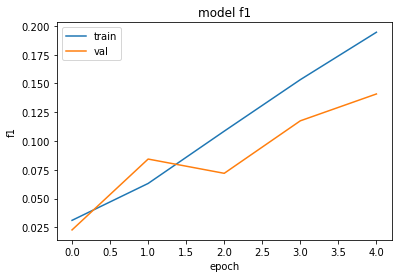

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Со свёрточным слоем

*Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Сделайте размер эмбединга сильно меньше. Попробуйте паддинг поменьше. Символьная модель может обучаться намного дольше. Иногда кернел может крашиться просто так или из-за слишком больших матриц.*

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(embeddings)

concat = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 120, 10)           580       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 118, 64)           1984      
_________________________________________________________________
flatten_4 (Flatten)          (None, 7552)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                483392    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 486,021
Trainable params: 486,021
Non-trainable params: 0
_____________________________________________________

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5)

Epoch 1/5
2424/2424 [==============================] - 179s 74ms/step - loss: 0.2048 - f1: 0.0011 - val_loss: 0.1955 - val_f1: 0.0058
Epoch 2/5
2424/2424 [==============================] - 173s 71ms/step - loss: 0.1923 - f1: 0.0090 - val_loss: 0.1918 - val_f1: 0.0266
Epoch 3/5
2424/2424 [==============================] - 172s 71ms/step - loss: 0.1874 - f1: 0.0320 - val_loss: 0.1872 - val_f1: 0.0571
Epoch 4/5
2424/2424 [==============================] - 176s 73ms/step - loss: 0.1827 - f1: 0.0722 - val_loss: 0.1863 - val_f1: 0.0808
Epoch 5/5
2424/2424 [==============================] - 172s 71ms/step - loss: 0.1778 - f1: 0.1221 - val_loss: 0.1871 - val_f1: 0.1247


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


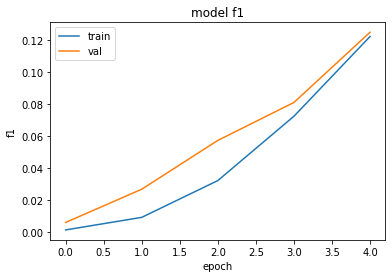

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('model')
model.load_weights('model.weights')

# Свёртка с дропаутом

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(embeddings)
drop1 = tf.keras.layers.Dropout(0.2)(conv1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 120, 10)           580       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 118, 64)           1984      
_________________________________________________________________
dropout_2 (Dropout)          (None, 118, 64)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 7552)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                483392    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65  

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.2065 - f1: 0.0037
Epoch 00001: val_f1 improved from -inf to 0.00050, saving model to model.weights
2424/2424 [==============================] - 257s 106ms/step - loss: 0.2065 - f1: 0.0037 - val_loss: 0.2018 - val_f1: 5.0403e-04
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1938 - f1: 0.0157
Epoch 00002: val_f1 improved from 0.00050 to 0.01844, saving model to model.weights
2424/2424 [==============================] - 259s 107ms/step - loss: 0.1938 - f1: 0.0157 - val_loss: 0.1906 - val_f1: 0.0184
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1880 - f1: 0.0427
Epoch 00003: val_f1 improved from 0.01844 to 0.03604, saving model to model.weights
2424/2424 [==============================] - 254s 105ms/step - loss: 0.1880 - f1: 0.0427 - val_loss: 0.1870 - val_f1: 0.0360
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1835 - f1: 0.0827
Epoch 00

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


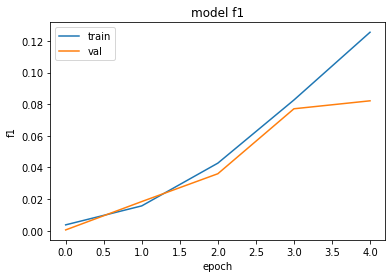

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Дропаут до свёртки

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(drop1)
concat = tf.keras.layers.Flatten()(conv1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 10)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 118, 64)           1984      
_________________________________________________________________
flatten_8 (Flatten)          (None, 7552)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                483392    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65  

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.2085 - f1: 0.0033
Epoch 00001: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 190s 79ms/step - loss: 0.2085 - f1: 0.0033 - val_loss: 0.1989 - val_f1: 3.8110e-04
Epoch 2/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1974 - f1: 0.0085
Epoch 00002: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 188s 78ms/step - loss: 0.1974 - f1: 0.0085 - val_loss: 0.1919 - val_f1: 0.0021
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1933 - f1: 0.0192
Epoch 00003: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 188s 78ms/step - loss: 0.1933 - f1: 0.0192 - val_loss: 0.1946 - val_f1: 0.0154
Epoch 4/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1907 - f1: 0.0310
Epoch 00004: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 188s 77ms/step - lo

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


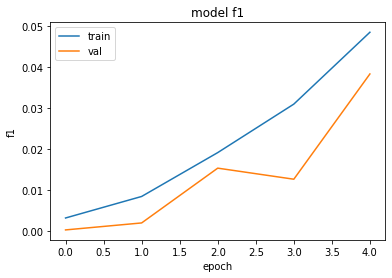

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Свёртка c меньшим дропаутом

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(embeddings)
drop1 = tf.keras.layers.Dropout(0.1)(conv1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 118, 64)           1984      
_________________________________________________________________
dropout_6 (Dropout)          (None, 118, 64)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 7552)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                483392    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65  

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.2054 - f1: 0.0026
Epoch 00001: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 256s 106ms/step - loss: 0.2054 - f1: 0.0026 - val_loss: 0.1948 - val_f1: 0.0086
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1923 - f1: 0.0156
Epoch 00002: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 257s 106ms/step - loss: 0.1923 - f1: 0.0156 - val_loss: 0.1888 - val_f1: 0.0165
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1873 - f1: 0.0491
Epoch 00003: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 260s 107ms/step - loss: 0.1873 - f1: 0.0491 - val_loss: 0.1864 - val_f1: 0.0478
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1825 - f1: 0.0915
Epoch 00004: val_f1 did not improve from 0.08215
2424/2424 [==============================] - 264s 109ms/step - lo

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


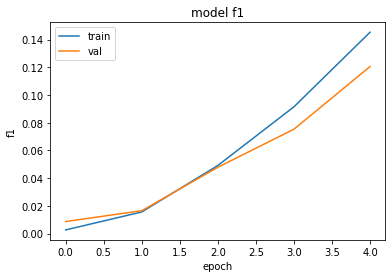

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Качество улучшилось от уменьшения дропаута

# Свёртка с пулингом и дропаутом

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(embeddings)
pool1 = tf.keras.layers.MaxPool1D()(conv1)
drop1 = tf.keras.layers.Dropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 118, 64)           1984      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 64)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 59, 64)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3776)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                241

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1916 - f1: 0.0555
Epoch 00001: val_f1 improved from 0.12054 to 0.18897, saving model to model.weights
2424/2424 [==============================] - 225s 93ms/step - loss: 0.1916 - f1: 0.0555 - val_loss: 0.1755 - val_f1: 0.1890
Epoch 2/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1720 - f1: 0.1880
Epoch 00002: val_f1 improved from 0.18897 to 0.21910, saving model to model.weights
2424/2424 [==============================] - 223s 92ms/step - loss: 0.1720 - f1: 0.1880 - val_loss: 0.1661 - val_f1: 0.2191
Epoch 3/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1652 - f1: 0.2497
Epoch 00003: val_f1 did not improve from 0.21910
2424/2424 [==============================] - 225s 93ms/step - loss: 0.1652 - f1: 0.2496 - val_loss: 0.1664 - val_f1: 0.1774
Epoch 4/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1598 - f1: 0.3005
Epoch 00004: val_f1 improved from 0.21910 to 0.

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


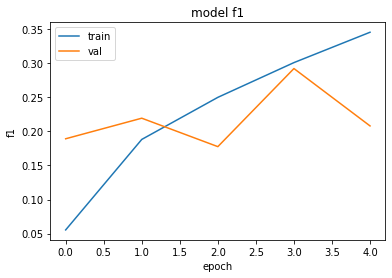

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# А если теперь дропаут увеличить?

Наверно, мы его неправильно применяем. То ли не в том месте, то ли другой дропаут нужен.

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(embeddings)
pool1 = tf.keras.layers.MaxPool1D()(conv1)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 118, 64)           1984      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 59, 64)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 3776)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                241

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1915 - f1: 0.0716
Epoch 00001: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 220s 91ms/step - loss: 0.1915 - f1: 0.0716 - val_loss: 0.1786 - val_f1: 0.2215
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1733 - f1: 0.1852
Epoch 00002: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 222s 91ms/step - loss: 0.1733 - f1: 0.1852 - val_loss: 0.1692 - val_f1: 0.1742
Epoch 3/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1688 - f1: 0.2260
Epoch 00003: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 218s 90ms/step - loss: 0.1688 - f1: 0.2260 - val_loss: 0.1670 - val_f1: 0.1750
Epoch 4/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1643 - f1: 0.2617
Epoch 00004: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 218s 90ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


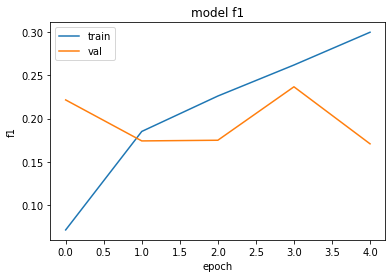

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Всё, что и было, но с двумя свёртками подряд

Только вернём дропаут 0.1. Cвёртка добавилась после той, что уже была

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=2, 
                               filters=32)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 118, 64)           1984      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 117, 32)           4128      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 58, 32)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 58, 32)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1856)              0  

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1899 - f1: 0.0707
Epoch 00001: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 281s 116ms/step - loss: 0.1899 - f1: 0.0707 - val_loss: 0.1819 - val_f1: 0.0460
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1719 - f1: 0.1963
Epoch 00002: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 284s 117ms/step - loss: 0.1719 - f1: 0.1963 - val_loss: 0.1656 - val_f1: 0.1685
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1652 - f1: 0.2578
Epoch 00003: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 283s 117ms/step - loss: 0.1652 - f1: 0.2578 - val_loss: 0.1617 - val_f1: 0.2579
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1607 - f1: 0.2936
Epoch 00004: val_f1 did not improve from 0.29182
2424/2424 [==============================] - 285s 117ms/step - lo

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


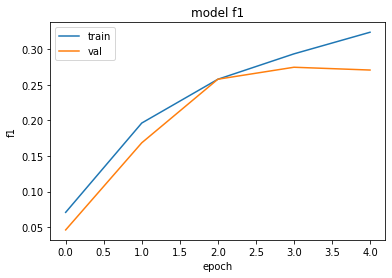

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Кажется, слишком сильно свернули. Свернем иначе

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=4, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
drop1 = tf.keras.layers.Dropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 117, 64)           2624      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 57, 64)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 3648)              0  

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1862 - f1: 0.0910
Epoch 00001: val_f1 improved from 0.29182 to 0.31988, saving model to model.weights
2424/2424 [==============================] - 473s 195ms/step - loss: 0.1862 - f1: 0.0910 - val_loss: 0.1754 - val_f1: 0.3199
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1645 - f1: 0.2568
Epoch 00002: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 479s 198ms/step - loss: 0.1645 - f1: 0.2568 - val_loss: 0.1598 - val_f1: 0.2773
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1579 - f1: 0.3117
Epoch 00003: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 478s 197ms/step - loss: 0.1579 - f1: 0.3117 - val_loss: 0.1559 - val_f1: 0.2825
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1532 - f1: 0.3488
Epoch 00004: val_f1 did not improve from 0.31988
2424/2424 [===================

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


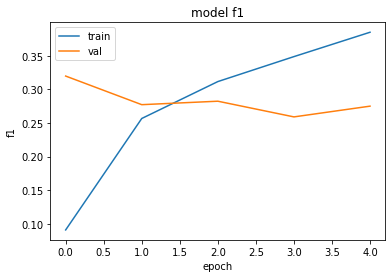

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Забыли про регуляризаторы. С регуляризаторами:

In [ ]:
%%time

inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64,
                               kernel_regularizer='l2')(embeddings)
pool1 = tf.keras.layers.MaxPool1D()(conv1)
drop1 = tf.keras.layers.Dropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 118, 64)           1984      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 59, 64)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 59, 64)            0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 3776)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                241

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])
# тут сравнивать нужно с односверточнослойной 0.19 0.05 на первой эпохе

Epoch 1/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.2117 - f1: 0.0104
Epoch 00001: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 222s 91ms/step - loss: 0.2117 - f1: 0.0104 - val_loss: 0.1961 - val_f1: 0.0074
Epoch 2/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1885 - f1: 0.0762
Epoch 00002: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 222s 92ms/step - loss: 0.1885 - f1: 0.0762 - val_loss: 0.1842 - val_f1: 0.0380
Epoch 3/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1830 - f1: 0.1280
Epoch 00003: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 221s 91ms/step - loss: 0.1830 - f1: 0.1280 - val_loss: 0.1834 - val_f1: 0.2046
Epoch 4/5
2423/2424 [============================>.] - ETA: 0s - loss: 0.1791 - f1: 0.1678
Epoch 00004: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 222s 92ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


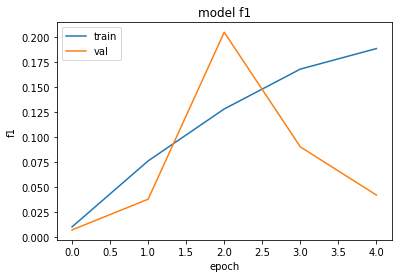

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Что-то регуляризатор всё сломал.

# Поменяем тип дропаута

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=4, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
drop1 = tf.keras.layers.AlphaDropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 117, 64)           2624      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 57, 64)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 3648)              0  

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.2098 - f1: 0.0017
Epoch 00001: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 481s 199ms/step - loss: 0.2098 - f1: 0.0017 - val_loss: 0.1977 - val_f1: 0.0016
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1931 - f1: 0.0082
Epoch 00002: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 482s 199ms/step - loss: 0.1931 - f1: 0.0082 - val_loss: 0.1891 - val_f1: 0.0270
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1822 - f1: 0.0789
Epoch 00003: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 485s 200ms/step - loss: 0.1822 - f1: 0.0789 - val_loss: 0.1880 - val_f1: 0.0870
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1739 - f1: 0.1741
Epoch 00004: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 486s 200ms/step - lo

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


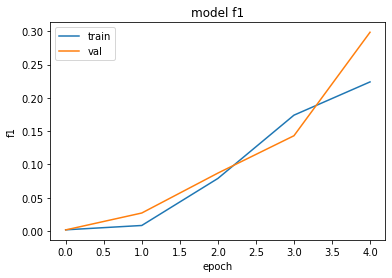

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Зря поменяли дропаут. Всё не радужно. Хотя интересно, что будет, если добавить эпох:

## Вообще без дропаута

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=4, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
# drop1 = tf.keras.layers.Dropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(pool1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 117, 64)           2624      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 3648)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                233

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1824 - f1: 0.1249
Epoch 00001: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 433s 179ms/step - loss: 0.1824 - f1: 0.1249 - val_loss: 0.1650 - val_f1: 0.1526
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1602 - f1: 0.2946
Epoch 00002: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 433s 179ms/step - loss: 0.1602 - f1: 0.2946 - val_loss: 0.1596 - val_f1: 0.2044
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1540 - f1: 0.3388
Epoch 00003: val_f1 did not improve from 0.31988
2424/2424 [==============================] - 431s 178ms/step - loss: 0.1540 - f1: 0.3388 - val_loss: 0.1669 - val_f1: 0.1511
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1495 - f1: 0.3680
Epoch 00004: val_f1 improved from 0.31988 to 0.42919, saving model to model.weights
2424/2424 [===================

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


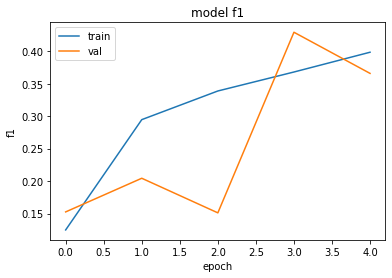

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Ещё один вид дропаута - GaussianDropout

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=4, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
# новый дропаут
# вообще SpatialDropout1D тоже как-то попробовала, но всё было плохо
drop1 = tf.keras.layers.GaussianDropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 117, 64)           2624      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 57, 64)            0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 3648)              0  

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1830 - f1: 0.1267
Epoch 00001: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 513s 212ms/step - loss: 0.1830 - f1: 0.1267 - val_loss: 0.1657 - val_f1: 0.2171
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1650 - f1: 0.2641
Epoch 00002: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 516s 213ms/step - loss: 0.1650 - f1: 0.2641 - val_loss: 0.1621 - val_f1: 0.2282
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1581 - f1: 0.3169
Epoch 00003: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 516s 213ms/step - loss: 0.1581 - f1: 0.3169 - val_loss: 0.1601 - val_f1: 0.2313
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1531 - f1: 0.3535
Epoch 00004: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 515s 212ms/step - lo

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


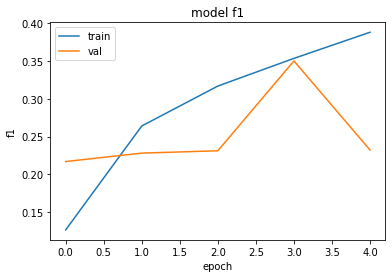

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Наконец, сделаем побольше слоёв

In [ ]:
# EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=2, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

convs = []

for ks in [2,3,4]:
    for fil in [64, 32]:
        for st in [1, 2]:
            conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=fil, padding='same', strides=1)(embeddings)
            conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same', strides=2, 
                                        #   kernel_regularizer='l2', 
                                        activation='relu')(conv1)
            pool1 = tf.keras.layers.MaxPool1D(2, strides=st, padding='same')(conv2)
            drop1 = tf.keras.layers.AlphaDropout(0.1)(pool1)
        convs.append(drop1)

concat = tf.keras.layers.concatenate(convs, axis=2)

conv_global = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=5,
          callbacks=[checkpoint, early_stop])

Epoch 1/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1930 - f1: 0.0576
Epoch 00001: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 1102s 455ms/step - loss: 0.1930 - f1: 0.0576 - val_loss: 0.1811 - val_f1: 0.0848
Epoch 2/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1712 - f1: 0.1990
Epoch 00002: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 1101s 454ms/step - loss: 0.1712 - f1: 0.1990 - val_loss: 0.1669 - val_f1: 0.1979
Epoch 3/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1619 - f1: 0.2803
Epoch 00003: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 1109s 458ms/step - loss: 0.1619 - f1: 0.2803 - val_loss: 0.1580 - val_f1: 0.2795
Epoch 4/5
2424/2424 [==============================] - ETA: 0s - loss: 0.1563 - f1: 0.3231
Epoch 00004: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 1098s 453ms/step 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


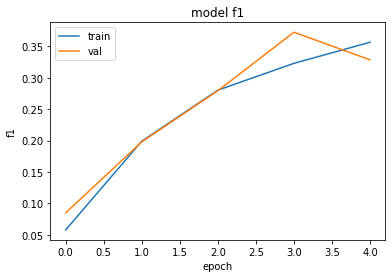

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Обучалось долго и улучшения не случилось - видимо, слишком рандомная архитектура.

Напоследок вернемся к простой архитектуре с альфадропаутом

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=4, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
drop1 = tf.keras.layers.AlphaDropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(drop1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 120)]             0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 120, 10)           580       
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 117, 64)           2624      
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 57, 64)            0         
_________________________________________________________________
alpha_dropout_74 (AlphaDropo (None, 57, 64)            0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 3648)              0  

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=15,
          callbacks=[checkpoint, early_stop])

Epoch 1/15
2424/2424 [==============================] - ETA: 0s - loss: 0.2133 - f1: 0.0072
Epoch 00001: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 489s 202ms/step - loss: 0.2133 - f1: 0.0072 - val_loss: 0.2014 - val_f1: 0.0142
Epoch 2/15
2424/2424 [==============================] - ETA: 0s - loss: 0.1892 - f1: 0.0735
Epoch 00002: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 488s 201ms/step - loss: 0.1892 - f1: 0.0735 - val_loss: 0.1987 - val_f1: 0.0296
Epoch 3/15
2424/2424 [==============================] - ETA: 0s - loss: 0.1789 - f1: 0.1506
Epoch 00003: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 489s 202ms/step - loss: 0.1789 - f1: 0.1506 - val_loss: 0.1752 - val_f1: 0.1753
Epoch 4/15
2424/2424 [==============================] - ETA: 0s - loss: 0.1724 - f1: 0.2032
Epoch 00004: val_f1 did not improve from 0.42919
2424/2424 [==============================] - 488s 201ms/step 

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Всё крашнулось... Ещё раз? Вообще говоря, лучшую метрику показала модель без дропаута.

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN, ))
embeddings = tf.keras.layers.Embedding(
    input_dim=len(sym2id), output_dim = 10)(inputs)

###################
conv1 = tf.keras.layers.Conv1D(kernel_size=4, 
                               filters=64)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, 
                               filters=64)(conv1)
pool1 = tf.keras.layers.MaxPool1D()(conv2)
# drop1 = tf.keras.layers.Dropout(0.1)(pool1)
concat = tf.keras.layers.Flatten()(pool1)
###################

dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=[f1])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 10)           920       
_________________________________________________________________
conv1d (Conv1D)              (None, 117, 64)           2624      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 115, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 57, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3648)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                233536

In [ ]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
2424/2424 [==============================] - ETA: 0s - loss: 0.1513 - f1: 0.3510
Epoch 00001: val_f1 improved from 0.36404 to 0.36959, saving model to model.weights
2424/2424 [==============================] - 439s 181ms/step - loss: 0.1513 - f1: 0.3510 - val_loss: 0.1535 - val_f1: 0.3696
Epoch 2/10
2424/2424 [==============================] - ETA: 0s - loss: 0.1462 - f1: 0.3871
Epoch 00002: val_f1 improved from 0.36959 to 0.37482, saving model to model.weights
2424/2424 [==============================] - 435s 180ms/step - loss: 0.1462 - f1: 0.3871 - val_loss: 0.1532 - val_f1: 0.3748
Epoch 3/10
2424/2424 [==============================] - ETA: 0s - loss: 0.1411 - f1: 0.4199
Epoch 00003: val_f1 did not improve from 0.37482
2424/2424 [==============================] - 452s 187ms/step - loss: 0.1411 - f1: 0.4199 - val_loss: 0.1609 - val_f1: 0.2610
Epoch 4/10
2424/2424 [==============================] - ETA: 0s - loss: 0.1356 - f1: 0.4578
Epoch 00004: val_f1 did not improve from

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


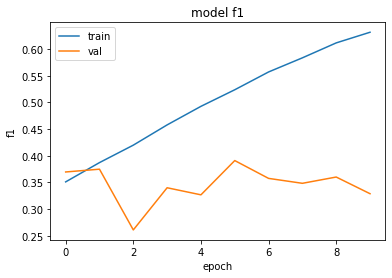

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Trash

In [ ]:
# влияние предобработки
def keep_alpha(s):
    matches = re.findall('[a-zA-Z\s]+', s)
    if matches:
        return re.sub('[\s\t\n]+', ' ', ''.join(matches))
def dig_token(s):
    return re.sub('[0-9]', '<DIG>', s)
def num_token(s):
    return re.sub('[0-9]+', '<NUM>', s)
# lower()

How did Otto von Guericke used the Magdeburg
How di.d Otto <DIG> <DIG><DIG><DIG> <DIG><DIG><DIG> von Guericke used <DIG>.<DIG><DIG> the Magdeburg?
How di.d Otto <NUM> <NUM> <NUM> von Guericke used <NUM>.<NUM> the Magdeburg?


In [ ]:
quora = pd.read_csv('quora.csv')

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(text.lower())

In [ ]:
len(vocab)

1949

In [ ]:
filtered_vocab = set()

for sym in vocab:
    if vocab[sym] > 20:
        filtered_vocab.add(sym)

len(filtered_vocab)

184

In [ ]:
sym2id = {'UNK':1, 'PAD':0}

for sym in filtered_vocab:
    sym2id[sym] = len(sym2id)

id2sym = {i:sym for sym, i in sym2id.items()}

X = []

for text in quora.question_text:
    syms = text.lower()
    ids = [sym2id.get(sym, 1) for sym in syms]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN, MEAN_LEN
MAX_LEN = MEAN_LEN + 50

In [ ]:
MAX_LEN = int(MAX_LEN)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape

(1306122, 110)

In [ ]:
y = quora.target.values
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, stratify=y)